In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
import numpy as np

In [2]:
# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size
batch_size = 32

train_generator = train_datagen.flow_from_directory('split_data/train', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('split_data/val', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('split_data/test', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Initialize and compile the model
densenet_model = create_densenet_model()
densenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_densenet = densenet_model.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the model
densenet_model.save('densenet_model.h5')


Found 8449 images belonging to 6 classes.
Found 2802 images belonging to 6 classes.
Found 1450 images belonging to 6 classes.
Epoch 1/50
265/265 [==============================] - 2623s 10s/step - loss: 0.9432 - accuracy: 0.6555 - val_loss: 2.2026 - val_accuracy: 0.5089
Epoch 2/50
265/265 [==============================] - 2528s 10s/step - loss: 0.7057 - accuracy: 0.7452 - val_loss: 3.0621 - val_accuracy: 0.4176
Epoch 3/50
265/265 [==============================] - 2527s 10s/step - loss: 0.6100 - accuracy: 0.7767 - val_loss: 0.8287 - val_accuracy: 0.7123
Epoch 4/50
265/265 [==============================] - 2551s 10s/step - loss: 0.5480 - accuracy: 0.8003 - val_loss: 0.8441 - val_accuracy: 0.7095
Epoch 5/50
265/265 [==============================] - 2520s 10s/step - loss: 0.5107 - accuracy: 0.8173 - val_loss: 1.0853 - val_accuracy: 0.6802
Epoch 6/50
265/265 [==============================] - 2530s 10s/step - loss: 0.4397 - accuracy: 0.8414 - val_loss: 0.8899 - val_accuracy: 0.7163
Epoc

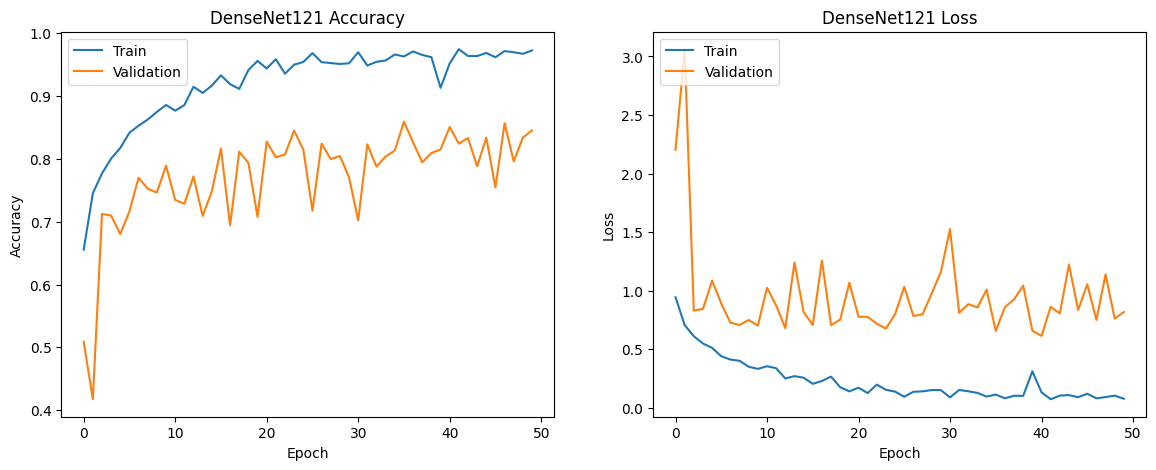

In [3]:
def plot_performance(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Plot performance for DenseNet121
plot_performance(history_densenet, 'DenseNet121')


In [4]:
# Compute mAP
y_true = test_generator.classes
y_pred_probs = densenet_model.predict(test_generator)

precision = dict()
recall = dict()
average_precision = dict()
n_classes = train_generator.num_classes

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

# Compute Mean Average Precision (mAP)
mean_average_precision = np.mean(list(average_precision.values()))
print(f'Mean Average Precision (mAP): {mean_average_precision}')

46/46 [==============================] - 76s 2s/step
Mean Average Precision (mAP): 0.16760641147849942


265/265 [==============================] - 418s 2s/step


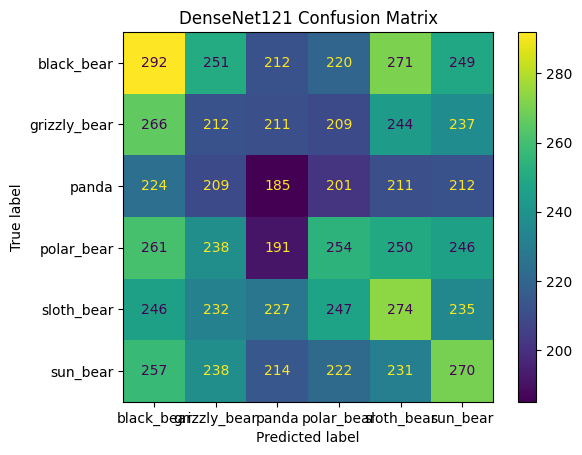

In [5]:
def plot_confusion_matrix(model, generator, model_name):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=generator.class_indices.keys()).plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot confusion matrix for DenseNet121
plot_confusion_matrix(densenet_model, train_generator, 'DenseNet121')    

In [6]:
train_loss, train_accuracy = densenet_model.evaluate(train_generator)
print(f'loss: {train_loss}, acc: {train_accuracy}')


265/265 [==============================] - 458s 2s/step - loss: 0.1186 - accuracy: 0.9672
loss: 0.1185554563999176, acc: 0.9672150611877441


In [15]:
test_loss, test_accuracy = densenet_model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

13/13 [==============================] - 21s 2s/step - loss: 1.4827 - accuracy: 0.7153
Test loss: 1.4827131032943726, Test accuracy: 0.7153284549713135


In [7]:
val_loss, val_accuracy = densenet_model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

88/88 [==============================] - 146s 2s/step - loss: 0.8178 - accuracy: 0.8451
Validation loss: 0.8178324103355408, Validation accuracy: 0.8451106548309326
